<a href="https://colab.research.google.com/github/ancastillar/Study-on-the-probability-of-payment-of-a-credit-requested-by-a-customer/blob/main/Model_LOAN_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is structured as follows:

*    Evaluate the disadvantages of implementing the logistic regression algorithm.

* Learn the basics concepts of Naive Bayes model.

* Learn about the how the algorithm works.

* Implementation of NB classifier.

* Contrast the performance between the algorithms: logistic regression and NB, for classification problems, using AUC/ROC metrics.




In [ ]:
import pandas as pd
import pydotplus
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

plt.style.use('ggplot')

from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency, norm
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from statsmodels.formula.api import ols
from sympy import var, plot_implicit, Eq

# ignore log(0) and divide by 0 warning
np.seterr(divide='ignore');

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_davivienda/Lending_club.csv',
                 dtype = {'loan_status':'category', 'annual_inc':'float',
                          'verification_status':'category', 'emp_length':'category',
                          'home_ownership':'category', 'int_rate':'object',
                          'loan_amnt':'float', 'purpose':'category',
                          'term':'category', 'grade':'category'})
df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float')

In [ ]:
df.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000.0,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500.0,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400.0,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000.0,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000.0,other,60 months,B


##Disadvantages of logistic regression##
Although logistic regression is one of the most commonly used classification algorithms, it is not the only one. If the underlying relationship between the logit of odds and the covariates is not linear, we need to consider higher order terms of the covariates to make the logistic model valid. Doing so requires a lot of tuning and experimenting. In such cases, it is often better to look at a classification algorithm that does not rely on a specific assumption about the relationship between the probability of the outcome and the covariates. Therefore we are going to introduce some of the most popular models

**Bayes Theorem**


To solve a problem using Bayesian methods, we have to specify two functions: the likelihood function p(X|θ),which describes the probability of observing a dataset X for a given value of the unknown parameters θ, and the prior distribution p(θ), which describes any knowledge we have about the parameters before we collect the data. Note that the likelihood should be considered as a function of the parameters θ with the data X held fixed. The prior distribution and the likelihood functionare used to compute the posterior distribution p(θ|X) via Bayes’ rule:
>  p($\theta$|X)=$\frac{p(X|\theta) \ p(\theta)}{\int d\theta'\ p(X|\theta')\ p(\theta')}$

In many cases, it will not be possible to analytically compute the normalizing constant in the denominator ofthe posterior distribution, p(X) =∫dθp(X|θ)p(θ),and Markov Chain Monte Carlo (MCMC) methods are needed to draw random samples from p(θ|X).[1]

**Deduction of Bayes Theorem**

Let B be an event whose chance of occurrence must be measured under the assumption that an event A has been observed. If the experiment is repeated, under the same conditions, n times then the relative frequency of B under condition A is defined as follows: 

> $fr(B|A)=\frac{n(A\cap B)}{n(A)}; if\quad n(A)>0$

where n(A∩B) is the number of success cases to A∩B. When the experiment is performed a large enough number of times, we have:

> $fr(B|A)=\frac{\frac{n(A\cap B)}{n}}{\frac{n(A)}{n}}; if\quad n(A)>0$

If n$\rightarrow \ \infty$, the last equation becomes:

>  $P(B|A)= \frac{P(A\cap B)}{P(A)}$

From the last equation we can define the independency (other important concept)of two events as follows:

> $P(A \cap B)= P(A)P(B)$


Recalling the following definitions we can get two important results:

> **sample space**: $\Omega=\{ \omega_n \}\quad n \in (0, \infty)$ $\quad$where $\omega_i\cap\omega_j=\phi$: 


**Total probability rule**

$P(B)= P(B\cap \Omega)$ = $P(\cup_n(B \cap \omega_n )$ = $\sum_n P(B\cap \omega_n)$ = $\sum_n P(B|\omega_n)P(\omega_n)$ 

from the last rule we get the next corollary:

Corollary:  Be it $\omega_1, \omega_2...$ a finite sample of $\Omega$ with P(A_i)> 0 for all $i$ we have:

> $P(\omega_i| B)=\frac{P(\omega_i) P(B| \omega_i)}{\sum_j P(B| \omega_j) P(\omega_j)} $


> Proof:

> $P(\omega_i|B)=\frac{P(\omega_i \cap B)}{P(B)}= \frac{P(\omega_i)P(B|\omega_i)}{P(B)}= \frac{P(\omega_i)P(B|\omega_i)}{\sum_j P(B|\omega_j)P(\omega_j)} $  


if $j\ \rightarrow \ \infty$ then:

> p($\omega$|X)=$\frac{p(X| \omega) \ p(\omega)}{\int d\omega'\ p(X|\omega')\ p(\omega')}$ 

The last equation is the continuous version of Bayes rule[2]

##Naive Bayes Clasiffier##

This algorithm is based on Bayes' theorem, which is a conditional probability theorem (see previous section). The principal idea for this project is:

> Given a client with certain characteristics, we will use Bayes' theorem and the observed data to estimate the probability that defaulters and non-defaulters have the same characteristics as the client. The larger of these two probabilities would then determine how we classify the client.

Let's go to determine whether $\text{P(defaulter| income verified)}$ is larger than $\text{P(non-defaulter| income verified)}$ using Bayes' theorem:


>  $\text{P(defaulter| income verified)}=\frac{\text{P(income verified|  defaulter)}\ \text{P(defaulter)}}{\text{P(income verified)}}$ ; $\text{P(non-defaulter|  income verified)}=\frac{\text{P(income verified|  non-defaulter)} \ \text{P(non-defaulter)}}{\text{P(income verified)}}$


In order to get the answer we need to do an assumption and verify if this is true or not:


>  $\text{P(defaulter|  income verified)} \ \text{P(defaulter)}$< $\text{P(non defaulter|  income verified)}\ \text{P(non-defaulter)}\quad (1)$




First we are going to calculate the probability $\text{P(defaulter)}$ and $\text{P(non-defaulter)}$:

In [ ]:
p_def=df[df['loan_status']=='Charged Off']['loan_status'].count()/df['loan_status'].count()
print('P(defaulter)={:.3f} \nP(non-defaulter)={:.3f}'.format(p_def, 1-p_def))

P(defaulter)=0.141 
P(non-defaulter)=0.859


Now we are goingt to calculate the probability $\text{P(income verified| defaulter)}$ and $\text{P(income verified| non-defaulter)}$:

In [ ]:
p_id=df[(df['loan_status']=='Charged Off') & (df['verification_status']=='Verified')]['loan_status'].count()/df[df['loan_status']=='Charged Off']['loan_status'].count()
p_ind=df[(df['loan_status']=='Fully Paid') & (df['verification_status']=='Verified')]['loan_status'].count()/df[df['loan_status']=='Fully Paid']['loan_status'].count()
print('P(income verified given defaulter)={:.3f} \nP(income verified given non-defaulter)={:.3f}'.format(p_id, p_ind))

P(income verified given defaulter)=0.363 
P(income verified given non-defaulter)=0.313


We can evaluate the equation (1)

In [ ]:
p_def_iv=p_id*p_def
p_ndef_iv=p_ind*(1-p_def)
print('P(defaulter|income verified)  is proportional to {:.3f}  \
\nP(non-defaulter|income verified) is proportional to {:.3f}'.format(p_def_iv, p_ndef_iv))

P(defaulter|income verified)  is proportional to 0.051  
P(non-defaulter|income verified) is proportional to 0.269


 If we only have information about the income verification status of our clients, we would probably give loans to those clients whose income has been verified. What happens if the client is either `Source Verified` or `Not Verified`? We can repeat the same procedure:

In [ ]:
p_id2=df[(df['loan_status']=='Charged Off') & (df['verification_status']=='Source Verified')]['loan_status'].count()/df[df['loan_status']=='Charged Off']['loan_status'].count()
p_ind2=df[(df['loan_status']=='Fully Paid') & (df['verification_status']=='Source Verified')]['loan_status'].count()/df[df['loan_status']=='Fully Paid']['loan_status'].count()

p_def_iv2=p_id2*p_def
p_ndef_iv2=p_ind2*(1-p_def)
print('P(defaulter|income source verified)  is proportional to {:.3f}  \
\nP(non-defaulter|income source verified) is proportional to {:.3f}'.format(p_def_iv2, p_ndef_iv2))

P(defaulter|income source verified)  is proportional to 0.037  
P(non-defaulter|income source verified) is proportional to 0.217


In [ ]:
p_id3=df[(df['loan_status']=='Charged Off') & (df['verification_status']=='Not Verified')]['loan_status'].count()/df[df['loan_status']=='Charged Off']['loan_status'].count()
p_ind3=df[(df['loan_status']=='Fully Paid') & (df['verification_status']=='Not Verified')]['loan_status'].count()/df[df['loan_status']=='Fully Paid']['loan_status'].count()

p_def_iv3=p_id3*p_def
p_ndef_iv3=p_ind3*(1-p_def)
print('P(defaulter|income not verified)  is proportional to {:.3f}  \
\nP(non-defaulter| income not verified) is proportional to {:.3f}'.format(p_def_iv3, p_ndef_iv3))

P(defaulter|income not verified)  is proportional to 0.053  
P(non-defaulter| income not verified) is proportional to 0.373


The conditional probabilities of being a non-defaulter are always bigger than those for being a defaulter, remenber that in the notebook of logistic regression we find a Simsonp paradox for the `verified_status` and `loan_status`

##The algorithm and assumptions##

There are two possible routes that we can follow to create a classification algorithm from Bayes' theorem.

#### Probabilistic Model

Recall that in logistic regression, the main quantity of interest is the probability of no default (remember that our encoding was 1 for non-defaulters and 0 for defaulters) given specific values for the covariates. We explicitly modeled this probability as a linear function of covariates after transformation by the logit function. 

The Naive Bayes classifier aims to estimate this probability from a different perspective. From Bayes' theorem, we can express this conditional probability in the following way:

$$\text{P(non-defaulter|covariates=values)} = \frac{\text{P(covariates=values| non-defaulter)P(defaulter)}}{\text{P(covariates=values)}}.$$

**Then, we create our classifier as in the logistic model by selecting a threshold $t$ and classify a client with given covariates values as a defaulter if:**

$$
\text{P(non-defaulter|covariates=values)}>t.
$$

#### Maximum A Posteriori Model (MAP)

For this classifier, a client with given covariates values is classified as a non-defaulter if:

$$
\text{P(non-defaulter|covariates=values)}>\text{P(defaulter|covariates=values)}
$$

which is equivalent to:

$\text{P(covariates=values|non-defaulter)P(non-defaulter)}>\text{P(covariates=values|defaulter)P(defaulter)}\tag{**}
$
**Note: This assumption is the same of the equation (1)**

Let's take a look at each of these quantities:

1. $\text{P(defaulter)}$ and $\text{P(non-defaulter)}$. These are the probabilities of having a defaulter and a non-defaulter. These can be easily estimated using the proportion of defaulters in the dataset.
2. $\text{P(covariates=values)}$. This is the probability of having a customer whose covariates are equal to $\text{values}$. This can also be estimated by proportions, but we will actually find out that it is not necessary to estimate this quantity at all (more on this later).
3. $\text{P(covariates=values| non-defaulter)}$ and $\text{P(covariates=values| defaulter)}$. We can estimate these by looking at the proportion of defaulters and non-defaulters with covariates equal to $\text{values}$. But if we have a lot of covariates, the number of such defaulters might be extremely small or even equal to zero. The main challenge in building a Naive Bayes classifier is estimating these particular probabilities.

Indeed, when the number of covariates is large, it is hard to estimate $\text{P(covariates=values given non-defaulter)}$ by proportions directly. For instance, suppose that we have 10 covariates and that all of them are binary variables. Then, the total number of possible values these covariates can take is equal to $2^{10}=1024$. Thus, in order to estimate $\text{P(covariates=values given non-defaulter)}$ we would need at least $1024$ samples! If we want to go even further, suppose we want to classify texts having most 82 words, where each word in the text has 10 possible alternatives. The number of samples we would need will be larger than the number of atoms in the universe!

##Assumption of Naive##

All classifiers start from a master algorithm and are differentiated from a different assumption for each classifier. For example, in this case,the Naive Bayes classifier makes the assumption that *all covariates are independent when conditioned on the outcome*.

$$
\text{P(covariates=values given non-defaulter)} = \text{P(covariate}_1\text{=value}_1\text{ given non-defaulter)}\times\cdots\times\text{P(covariate}_p\text{=value}_p\text{ given non-defaulter)}
$$


IMPORTANT: **Here we assume there are $p$ covariates in total. This significantly reduces the amount of samples required for the estimation! For instance, consider the example with 10 covariates, all of which are binary variables. Here, we need to estimate 10 simpler conditional probabilities and each one of them only concerns one binary variable, which has 2 possible outcomes. So we only need at least $2×10=20$ samples now, which is much smaller than $1024$.**

##What about continuous covariates?##
Computing proporitions works great for calculating the probabilities for discrete covariates. But what about variables like `annual_inc` that take on a continuous range of values? For these, we need to fit a *distribution* to the data. In the natural world, many things are governed by a normal distribution. To fit a normal distribution, all we need to specify is its mean and variance. The normal distribution with mean equal to the sample mean and variance equal to the sample variance of the covariate turns out to be a very good approximation. Once we get this normal distribution, the probabilities can be calculated directly for any covariate value.


Find the normal distribution that most aligned with the observed distribution of `annual_inc` in defaulters. Based on this normal distribution, calculate $\text{P(annual_inc=10,000|defaulter)}$. Function `pdf()` in `scipy.stats.norm` 
calculates the density of a normal distribution at a given value.

Let's fit the continuous variables with some distribution in this case (normal):

In [ ]:
df_default = df[df['loan_status']=='Charged Off']
df_ndefault=df[df['loan_status']=='Fully Paid']

mean_est = df_default['annual_inc'].mean()
var_est = df_default['annual_inc'].var()

# pdf takes standard deviation as scale parameter
# note we have log10 transformed annual_inc so when call norm.pdf, we should evaluate at 4
print(f"P(annual_inc=10,000|defaulter) = {norm.pdf(10000, loc = mean_est, scale = np.sqrt(var_est))}")

P(annual_inc=10,000|defaulter) = 4.473123137400813e-06


The last exercise was very easy to obtain from the data but, what about the inverse case? $\text{P(defaulter|annual_inc=10,000)}$ It is not trivial, right?

Now, we claim that we can use the following procedure to get $\text{P(non-defaulter|covariates=values)}$:

1. Estimate $\text{P(defaulter)}$ and $\text{P(non-defaulter)}$.
2. Estimate $\text{P(covariates=values|defaulter)}$ and $\text{P(covariates=values given non-defaulter)}$
3. Estimate $\text{P(non-defaulter|covariates=values)}$ with the following equation:

$$
    \frac{\text{P(covariates=values| non-defaulter)}\text{P(non-defaulter)}}{\text{P(covariates=values|defaulter)}\text{P(defaulter)}+\text{P(covariates=values|non-defaulter)}\text{P(non-defaulter)}}
$$

##Feature engenier##

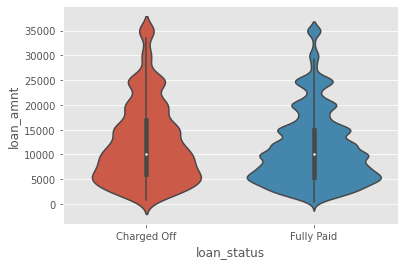

In [ ]:
# plot the distribution of the continuous variable
sns.violinplot(x='loan_status', y='loan_amnt', data=df);

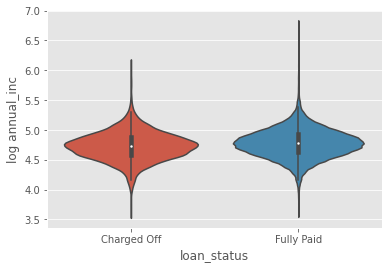

In [ ]:
#We have to standardize  this variable to view better results
ax = sns.violinplot(x=df['loan_status'], y=np.log10(df['annual_inc']));
ax.set(ylabel='log annual_inc');

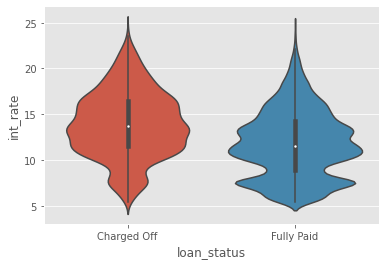

In [ ]:
sns.violinplot(x='loan_status', y='int_rate', data=df);
 #Here the distribution are very different in the two types of users


However, the distribution for `int_rate` is close enough to normal, but that of `loan_amnt` seems a bit skewed (although nowhere near the degree of `annual_inc`. Let's apply a square root transformation:

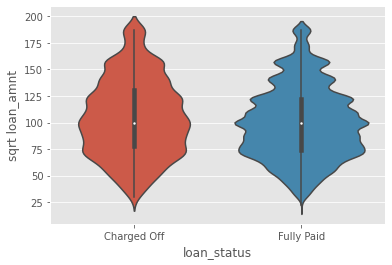

In [ ]:
ax = sns.violinplot(x = df['loan_status'], y = np.sqrt(df['loan_amnt']));
ax.set(ylabel='sqrt loan_amnt');

From the above exercise, we find that we need to transform `annual_inc` and `loan_amnt` so that the normality assumption can be approximately satisfied. We will use the transformed variables to construct the Naive Bayes estimator:

In [ ]:
df['annual_inc_log'] = np.log10(df['annual_inc'])
df['loan_amnt_sqrt'] = np.sqrt(df['loan_amnt'])

## **Implementing the classifier**------------------------------------**Algorithm**----------------------------------

In [ ]:
#function to fit the continous variables a normal distribution

"""
Learn parameters for continuous covariate
y is a binary outcome
X is a pandas series of a continuous covariate
"""
def nb_fit_con(y, X):
    y_code = y.cat.codes
    X_0 = X[y_code==0]
    X_1 = X[y_code==1]
    return [[np.mean(X_0), np.std(X_0)], [np.mean(X_1), np.std(X_1)]]

Next, we write a function `nb_fit_dis` to estimate the probabilities of each level of a discrete covariate in defaulters and non-defaulters:

In [ ]:
"""
Learn parameters for discrete covariate
y is a binary outcome
X is a pandas series of a discrete covariate
"""
def nb_fit_dis(y, X):
    y_code = y.cat.codes
    X_code = X.cat.codes
    X_nlvl = len(X.cat.categories)
    
    X_0 = X_code[y_code==0]
    X_1 = X_code[y_code==1]
    
    X_0_freq = [np.sum(X_0==x)/len(X_0) for x in range(X_nlvl)]
    X_1_freq = [np.sum(X_1==x)/len(X_1) for x in range(X_nlvl)]
    return [X_0_freq, X_1_freq]

The following function uses the two estimation functions we wrote above to train a Naive Bayes classifier:

In [ ]:
"""
y is a binary outcome
X is a pandas dataframe of covariates
"""
def train_nb_classifier(y, X):
    trained_model = {}
    for ind_col in X.columns:
        # check data type
        if X[ind_col].dtype=='float':
            params_fit = nb_fit_con(y, X[ind_col])
        else:
            params_fit = nb_fit_dis(y, X[ind_col])
        trained_model[ind_col] = params_fit
    margin_p_0 = np.sum(y.cat.codes==0)/len(y)
    trained_model['margin_p'] = [margin_p_0, 1-margin_p_0]
    return trained_model

Once the model is trained, the following function `predict_nb_classifier` predicts the probability of not defaulting for new samples:

In [ ]:
"""
log of normal density
"""
def log_dnorm(x, loc, scale):
    return -(x-loc)**2/2/(scale**2) - np.log(scale) - 0.5*np.log(2*np.pi)

"""
prediction
X_test: a pandas dataframe of covariates for prediction
        discrete vars have the same coding scheme as in the train dataset
"""

def predict_nb_classifier( nb_fit, X_test ):
    pred_0_p = np.ones(X_test.shape[0] )*np.log(nb_fit['margin_p'][0])
    pred_1_p = np.ones(X_test.shape[0] )*np.log(nb_fit['margin_p'][1])
    
    for ind_col in X_test.columns:
        params = nb_fit[ind_col]
        if X_test[ind_col].dtype=='float':
            #increment prob for outcome 0 for all samples
            update_0 = log_dnorm(X_test[ind_col], loc = params[0][0], scale = params[0][1])
            update_1 = log_dnorm(X_test[ind_col], loc = params[1][0], scale = params[1][1])
        else:
            update_0 = [np.log(params[0][x]) for x in X_test[ind_col].cat.codes]
            update_1 = [np.log(params[1][x]) for x in X_test[ind_col].cat.codes]
        pred_0_p = pred_0_p + update_0
        pred_1_p = pred_1_p + update_1
    
    #calculate the estimated probability of outcome=1
    #specifically handle Inf
    p_ratio = np.exp(pred_1_p-pred_0_p)
    p_1 = p_ratio/(1+p_ratio)
    p_1[p_ratio==np.Inf] = 1
    
    return p_1

In [ ]:
def cv_roc_nb(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        nb_trained = train_nb_classifier(y.iloc[train], X.iloc[train])
        probas_ = predict_nb_classifier(nb_trained, X.iloc[test])
        
        # Compute ROC curve and area the curve
        
        fpr, tpr, thresholds = roc_curve(y.iloc[test].cat.codes, probas_)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

In [ ]:
# fit NB
tprs_nb, aucs_nb, mean_fpr_nb = cv_roc_nb(df[['term', 'verification_status', 'annual_inc_log']], df['loan_status'], 5)

In [ ]:
#@title LogisticR DATA
# normalize and set-up the data
df_log = pd.concat([(df['loan_amnt'] - df['loan_amnt'].mean())/df['loan_amnt'].std(),
                     (df['int_rate'] - df['int_rate'].mean())/df['int_rate'].std(),
                     (df['annual_inc'] - df['annual_inc'].mean())/df['annual_inc'].std(),
                     pd.get_dummies(df['home_ownership'], prefix='home', drop_first=True),
                     pd.get_dummies(df['purpose'], prefix='purpose', drop_first=True),
                     pd.get_dummies(df['grade'], prefix='grade', drop_first=True)], axis=1)
df_log['verification_status'] = df['verification_status'].cat.codes
df_log['emp_length'] = df['emp_length'].cat.codes
df_log['term'] = df['term'].cat.codes
df_log['Intercept'] = 1

# fit the logistic regression model
logit_full1 = sm.Logit(df['loan_status'].cat.codes, df_log)
logit_full1_res = logit_full1.fit()
predict_withvs = logit_full1_res.predict(df_log)

# generate cross-validated ROC and AUC for logistic regression model

def cv_roc(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        logit = sm.Logit(y.iloc[train], X.iloc[train])
        logit_res = logit.fit(disp=0)
        probas_ = logit_res.predict(X.iloc[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

Optimization terminated successfully.
         Current function value: 0.378195
         Iterations 7


In [ ]:
# fit logistic
tprs_lgs, aucs_lgs, mean_fpr_lgs = cv_roc(df_log[['Intercept', 'term', 'verification_status', 'annual_inc']], df['loan_status'].cat.codes, 5)


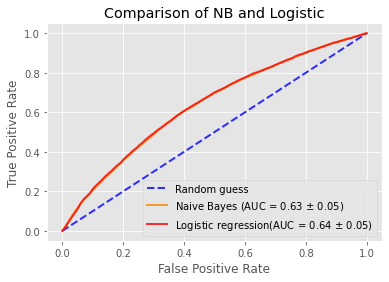

In [ ]:
#Comparation
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
         label='Random guess', alpha=.8)

mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_nb[-1] = 1.0
mean_tpr_lgs = np.mean(tprs_lgs, axis=0)
mean_tpr_lgs[-1] = 1.0

mean_auc_nb = auc(mean_fpr_nb, mean_tpr_nb)
std_auc_nb = np.std(aucs_nb)
mean_auc_lgs = auc(mean_fpr_lgs, mean_tpr_lgs)
std_auc_lgs = np.std(aucs_lgs)

plt.plot(mean_fpr_nb, mean_tpr_nb, color='darkorange', lw=2, alpha=.8,
         label=f"Naive Bayes (AUC = {mean_auc_nb:0.2f} $\pm$ {std_auc_nb:0.2f})")
plt.plot(mean_fpr_lgs, mean_tpr_lgs, color='red', lw=2, alpha=.8,
         label=f"Logistic regression(AUC = {mean_auc_lgs:0.2f} $\pm$ {std_auc_lgs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Comparison of NB and Logistic')
plt.show()

## Conclusions 

In this case, we learned about a few new classification models and the advantages and disadvantages they have versus the standard logistic model. We learned that the Naive Bayes classifier, although "naive", generally does not suffer much and in fact is the fastest to train. Furthermore, the implementation of Naive Bayes is quite math-heavy and relies on a simplifying assumption of independence. This makes Naive Bayes bad when covariates are obviously dependent.
Note: For the Naive Bayes classifier can assume distributions other than the normal distribution a get better results.

#References

[1] Pankaj Mehta, Ching-Hao Wang, Alexandre G. R. Day, and Clint Richardson, A high-bias, low-variance introduction to Machine Learning for physicists. 27 May 2019. https://arxiv.org/pdf/1803.08823.pdf

[2] Liliana Blanco, Probabilidad. Universidad Nacional de Colombia. Facultad de Ciencias 2004.

[3] DS4A Correlation 3.0, Course materials, 2020.